<a href="https://colab.research.google.com/github/naza-campioni/fishery-models-tutorial/blob/main/VPA/vpa_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VPA - virtual population analysis model for stock assessment

needed:
1. catch in numbers C_{a,y} (data)
1. guess for natural mortality M
2. guess for terminal fishing mortality F_{A,Y}

from this we can estimate survivors, N_{A,Y}

then (by using Pope's approximation on fishing happening all at mid-year):

    N_{a,y} = N_{A,Y} e^M + C_{a,y}e^{M/2}



In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# stock assessment model VPA
# assuming 5 years and 7 ages, the matrix is a x y
a = 5
y = 7
C_ay = np.matrix([np.random.randint(low=500, high=1500, size=y),
                          np.random.randint(low=500, high=1500, size=y),
                          np.random.randint(low=500, high=1500, size=y),
                          np.random.randint(low=500, high=1500, size=y),
                          np.random.randint(low=500, high=1500, size=y)])

M = 0.2
F_AY = 0.3

N_AY = np.zeros([1,a])

# use Baranov's equation to calculate N_{A,Y}
# F_AY and M are constant within year
den = 1 - np.exp(-(M + F_AY))
for i in range(a):
  N_AY[0,i] = (C_ay[4,i] / den) * ((F_AY + M) / F_AY)




In [3]:
# vectorized version
N_ay = np.zeros([a,y])
N_ay[:,-1] = N_AY.flatten() # survivors

# the last group age is tricky - it'd need a_MAX + 1 which doesn't
# exist, so we assume all age classes beyond a_MAX are just a_MAX

for i in reversed(range(y-1)):
  # calculate until last age class
  N_ay[:-1,i] = N_ay[1:,i+1] * np.exp(M) + C_ay[:-1,i].T * np.exp(M/2)

  # then here we'd need N_ay[a_MAX + 1, y] so we just use N_ay[a_MAX]
  N_ay[-1,i] = N_ay[-1, i+1] * np.exp(M) + C_ay[-1,i].T * np.exp(M/2)

print('\nReconstructed population at age: \n\n {}'.format(N_ay))


Reconstructed population at age: 

 [[26713.65630329 20040.50841671 15609.05899652  9197.18252344
   6940.08639143  4973.69917433  5222.77033961]
 [26455.30554657 21081.36887671 15542.75597643 11474.84107025
   6621.5594059   5207.02251321  2812.58678467]
 [25540.07273775 20407.47724649 16413.94203048 12040.37038004
   8451.05984389  4806.8897121   3329.35724812]
 [24978.20144665 19821.01873493 16025.98180124 12839.59674885
   8845.30843781  6109.31310115  3409.83789407]
 [25685.51083422 19913.85309205 15703.27189316 12145.5494123
   9215.54069536  6622.11240714  4320.53994031]]


In [4]:
# now we calculate all of N_a,y backwards in a loop
N_ay = np.zeros([a,y])
N_ay[:,-1] = N_AY.flatten() # survivors

for i in reversed(range(y-1)):
  for j in reversed(range(a)):
    if j == a-1: # if at a_MAX
      N_ay[j,i] = N_ay[j,i+1]*np.exp(M) + C_ay[j,i]*np.exp(M/2)
    else:
      N_ay[j,i] = N_ay[j+1,i+1]*np.exp(M) + C_ay[j,i]*np.exp(M/2)

print('\nReconstructed population at age: \n\n {}'.format(N_ay))


Reconstructed population at age: 

 [[26713.65630329 20040.50841671 15609.05899652  9197.18252344
   6940.08639143  4973.69917433  5222.77033961]
 [26455.30554657 21081.36887671 15542.75597643 11474.84107025
   6621.5594059   5207.02251321  2812.58678467]
 [25540.07273775 20407.47724649 16413.94203048 12040.37038004
   8451.05984389  4806.8897121   3329.35724812]
 [24978.20144665 19821.01873493 16025.98180124 12839.59674885
   8845.30843781  6109.31310115  3409.83789407]
 [25685.51083422 19913.85309205 15703.27189316 12145.5494123
   9215.54069536  6622.11240714  4320.53994031]]


Text(0.5, 1.0, 'Cohort-based population dynamics')

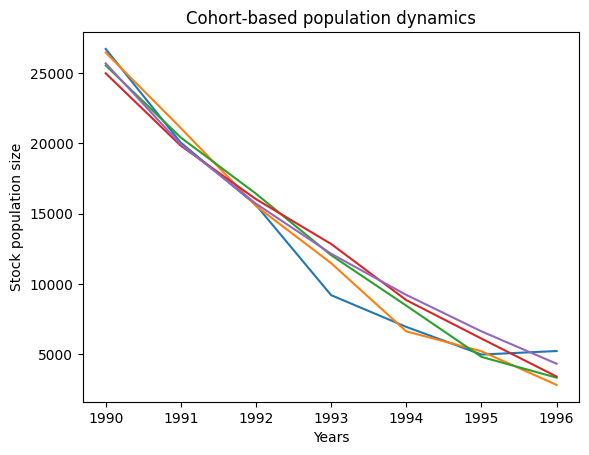

In [11]:
years = ['1990', '1991', '1992', '1993', '1994', '1995', '1996']
for i in range(a):
  plt.plot(years,N_ay[i])

plt.xlabel('Years')
plt.ylabel('Stock population size')
plt.title('Cohort-based population dynamics')

Next we can recover the fishing mortality rates F_{a,y}. How can we do that? We have two options:
1. use the exponential decay relation between next-year, next-age populations;
2. solve the Baranov's equation.

For the first solution, we can simply recover F_{a,y} as follows:

    N_{a+1,y+1} = N_{a,y}e^-(F_{a,y} + M)
    ie
    F_{a,y} = ln(N_{a,y}) - ln(N_{a+1,y+1}) - M
However, the underlying assumption is that the fishing mortality rate comes from the exponential relation between next-year and next-age populations, therefore it is not taking into consideration the information coming from the catches C_{a,y}. To leverage this information, we need to solve the Baranov's equation for F_{a,y}, which, being nonlinear, requires numerical approximation.